# RoboSINDy: Project Introduction

**Authors**: Julian Skifstad and Advaith Balaji

This notebook implements the paper "Data-driven discovery of coordinates and governing equations" by Champion et al. on the Franka Panda Arm. The goal is to compare this method with e2c. This work aims to explore and evaluate the performance of these approaches in a robotic planar pushing task.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm
import time

In [133]:
from utils.panda_pushing_env import PandaImageSpacePushingEnv
from utils.visualizers import GIFVisualizer, NotebookVisualizer
from utils.utils import *
from sindy.SINDy import RoboSINDy, SindyDataset, NormalizationTransform, PushingImgSpaceController, img_space_pushing_cost_function
from utils.panda_pushing_env import TARGET_POSE_FREE, TARGET_POSE_OBSTACLES, OBSTACLE_HALFDIMS, OBSTACLE_CENTRE, BOX_SIZE

Visualize panda arm environment in gym. Executes 3 random pushes.

In [ ]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaImageSpacePushingEnv(visualizer=visualizer,
                                render_non_push_motions=True,
                                camera_heigh=800,
                                camera_width=800,
                                grayscale=True,
                                done_at_goal=False)
env.reset()
# Perform a sequence of 3 random actions:
states = []
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    states.append(state)
    if done:
        break

view_states(states)

plt.close(fig)

Collect a dataset npy file that also included the state_derivatives. This will open the npy file in dataset_path and compute the state discrete time derivatives using central difference formula. It will then repackage states, actions, and state derivatives into a new .npy file which we can use as our dataset.

In [ ]:
dataset_path = "datasets/pushing_image_data.npy"
dt = 1/240.0 # time step in pybullet


data_npy = np.load(dataset_path, allow_pickle=True)

samples = []
for item in data_npy:
    
    states = item['states']
    actions = item['actions']
    state_derivatives = []
    for i in range(1, len(states)-1):
        state_derivative = (states[i+1] - states[i-1]) / dt
        state_derivatives.append(state_derivative)
    state_derivatives = np.array(state_derivatives)

    for i, state in enumerate(states[1:-1]):
        sample = {
            'state': state,
            'action': actions[i],
            'state_derivative': state_derivatives[i]
        }
        samples.append(sample)

# print info about samples
print(f"Number of samples: {len(samples)}")
print(f"Sample state shape: {samples[0]['state'].shape}")
print(f"Sample action shape: {samples[0]['action'].shape}")
print(f"Sample state derivative shape: {samples[0]['state_derivative'].shape}")

In [ ]:
# Some training and datset parameters
val_fraction = 0.2
batch_size = 64
num_epochs = 50000

The cell below will construct the Dataset used for RoboSINDy. It reads each sample from the .npy samples we created, normalizes each state and state derivatives, and constructs a dataloader to be used for training.

In [ ]:
dataset = SindyDataset(data=samples)

val_size = int(val_fraction * len(dataset))
train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

tot_train_states = []
tot_train_state_derivatives = []
for i in range(len(train_loader.dataset)):
    s = train_loader.dataset[i]['states']   
    sd = train_loader.dataset[i]['state_derivatives']  
    tot_train_states.append(s.unsqueeze(0))
    tot_train_state_derivatives.append(sd.unsqueeze(0))
tot_train_states = torch.cat(tot_train_states,dim=0)  
tot_train_state_derivatives = torch.cat(tot_train_state_derivatives, dim=0)  # (N,C,H,W)

mean_s = tot_train_states .mean(dim=(0,2,3))
std_s = tot_train_states .std( dim=(0,2,3))
mean_sd = tot_train_state_derivatives.mean(dim=(0,2,3))
std_sd = tot_train_state_derivatives.std( dim=(0,2,3))

normalization_constants = {
  'mean_state': mean_s,              
  'std_state':  std_s,               
  'mean_state_derivative': mean_sd,  
  'std_state_derivative': std_sd,    
}

norm_tr = NormalizationTransform(normalization_constants)
train_data.dataset.transform = norm_tr
val_data.dataset.transform = norm_tr

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

print(f"Loaded {len(train_loader.dataset)} training samples and {len(val_loader.dataset)} validation samples.\n")

# get one sample and check quality
sample = train_loader.dataset[0]
print(f"Sample state shape: {sample['states'].shape}")
print(f"Sample action shape: {sample['actions'].shape}")
print(f"Sample state derivative shape: {sample['state_derivatives'].shape}")
print(f"Sample state: {sample['states']}")


# Part 1: SINDy Dynamics model with 2 latent dimensions

#### We first train a model that learns the latent dynamics of the planar pushing task with 2 latent variables. The hope is that the 2 latent variables will each capture the dynamics of the object in the $x$ and $y$ direction.

In [ ]:
#define the model
model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size)

model.train_model(train_loader, num_epochs=num_epochs, learning_rate=0.001)

#save the model
model_path = 'trained_models/sindy_model.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Load model from .pt file. Skip if you just trained the model!

In [137]:
#load model from state dict

### SET THE PATH TO YOUR MODEL HERE ###
model_path = 'trained_models/sindy_model_v2_latent2.pt'
########################################

sindy_dynamics_model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=2)
sindy_dynamics_model.load_state_dict(torch.load(model_path))
sindy_dynamics_model.eval()
print(f"Model loaded from {model_path}")

Model loaded from trained_models/sindy_model_v2_latent2.pt


In [145]:
sindy_dynamics_model.xi_coefficients.data = mask_xi_matrix(sindy_dynamics_model.xi_coefficients.data)

print("Xi coefficients:")
print(sindy_dynamics_model.xi_coefficients.data.numpy())

Xi coefficients:
[[ 0.         0.       ]
 [-0.         1.7897408]
 [ 0.9017911 -0.       ]
 [ 0.         0.       ]
 [-0.         0.       ]
 [ 0.         0.       ]]


Visualize the robot pushing the block using the image space dynamics inferred by SINDy.

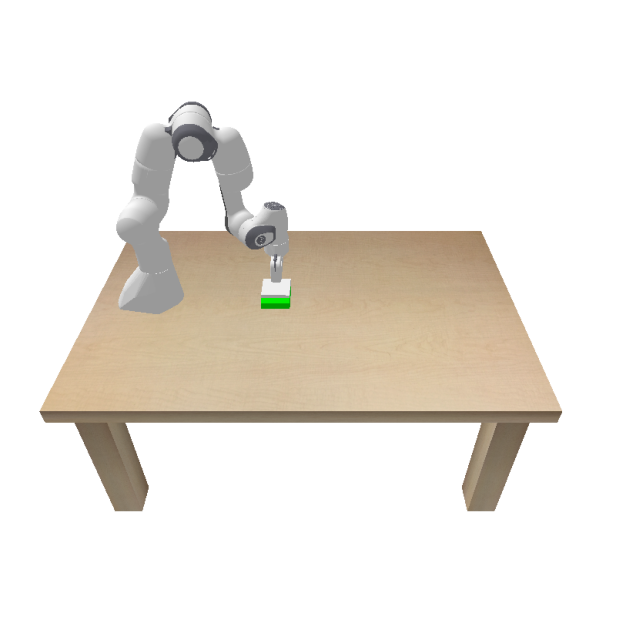

argv[0]=--opengl2
GOAL REACHED: True


In [142]:
import pybullet as p

# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# start_state = np.array([0.4, 0.0, 0.0])
# target_state = np.array([0.7, 0.0, 0.0])

start_state = np.array([0.4, 0.3, -np.pi/2])
target_state = np.array([0.4, -0.0, 0.0])

# start_state = np.array([0.3, 0.3, np.pi])
# target_state = np.array([0.0, 0.3, 0.0])

# start_state = np.array([0.0, 0.3, 0.0])
# target_state = np.array([0.6, 0.2, 0.0])


env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=1, grayscale=True, target_pose_vis=target_state, start_state=start_state)
env.object_target_pose = env._planar_pose_to_world_pose(target_state)
state_0 = env.reset()
controller = PushingImgSpaceController(env, sindy_dynamics_model, img_space_pushing_cost_function, normalization_constants, num_samples=100, horizon=10)

state = state_0

num_steps_max = 1000

goal_reached = False
for i in range(num_steps_max):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)

    # check if we have reached the goal
    end_pose = env.get_object_pos_planar()
    goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
    goal_reached = goal_distance < BOX_SIZE/2
    if done or goal_reached:
        break


print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)

# Part 2: SINDy Dynamics model with 3 latent dimensions

#### We will now train a model that learns the latent dynamics of the planar pushing task with **3** latent variables. This model will likely be more expressive. 

In [ ]:
#define the model
model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=3)

model.train_model(train_loader, num_epochs=num_epochs, learning_rate=0.001)

#save the model
model_path = 'trained_models/sindy_model_v3_latent3.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [113]:
#load model from state dict

### SET THE PATH TO YOUR MODEL HERE ###
model_path = 'trained_models/sindy_model_v3_latent3.pt'
########################################

sindy_dynamics_model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=3)
sindy_dynamics_model.load_state_dict(torch.load(model_path))
sindy_dynamics_model.eval()
print(f"Model loaded from {model_path}")

Model loaded from trained_models/sindy_model_v3_latent3.pt


In [ ]:
sindy_dynamics_model.xi_coefficients.data = mask_xi_matrix(sindy_dynamics_model.xi_coefficients.data)

print("Xi coefficients:")
print(sindy_dynamics_model.xi_coefficients.data.numpy())

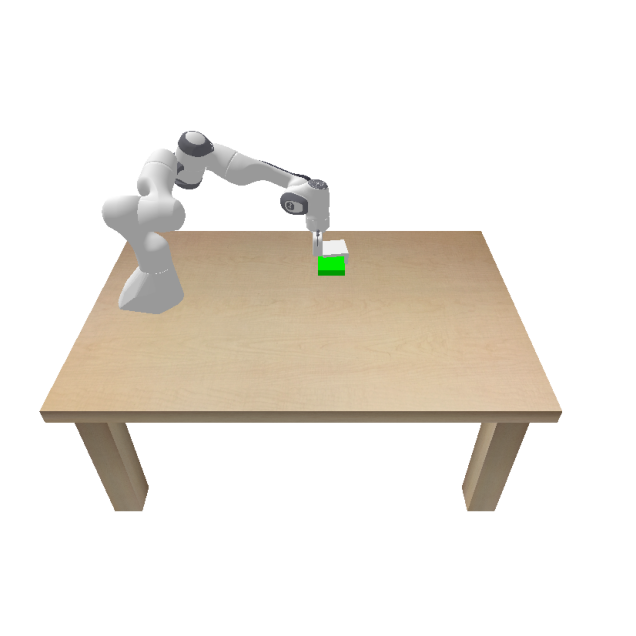

argv[0]=--opengl2
GOAL REACHED: True


In [ ]:
import pybullet as p

# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

start_state = np.array([0.4, 0.0, 0.0])
target_state = np.array([0.7, 0.0, 0.0])

# start_state = np.array([0.3, 0.3, -np.pi/2])
# target_state = np.array([0.3, -0.0, 0.0])

# start_state = np.array([0.3, 0.3, np.pi])
# target_state = np.array([0.0, 0.3, 0.0])

# start_state = np.array([0.0, 0.3, 0.0])
# target_state = np.array([0.6, 0.2, 0.0])


env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=1, grayscale=True, target_pose_vis=target_state, start_state=start_state)
env.object_target_pose = env._planar_pose_to_world_pose(target_state)
state_0 = env.reset()
controller = PushingImgSpaceController(env, sindy_dynamics_model, img_space_pushing_cost_function, normalization_constants, num_samples=100, horizon=10)

state = state_0

num_steps_max = 1000

goal_reached = False
for i in range(num_steps_max):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)

    # check if we have reached the goal
    end_pose = env.get_object_pos_planar()
    goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
    goal_reached = goal_distance < BOX_SIZE/2
    if done or goal_reached:
        break


print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)

# Part 3: SINDy Dynamics model with 1 latent dimension

#### We will now train a model that learns the latent dynamics of the planar pushing task with **1** latent variable. I wonder what this will recover?

In [ ]:
# TRAIN MODEL WITH LATENT DIMENSION 1

#define the model
model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=1)

model.train_model(train_loader, num_epochs=num_epochs, learning_rate=0.001)

#save the model
model_path = 'trained_models/sindy_model_v4_latent1.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [127]:
#load model from state dict

### SET THE PATH TO YOUR MODEL HERE ###
model_path = 'trained_models/sindy_model_v4_latent1.pt'
########################################

sindy_dynamics_model = RoboSINDy(input_dim=32*32*1, batch_size=batch_size, latent_dim=1)
sindy_dynamics_model.load_state_dict(torch.load(model_path))
sindy_dynamics_model.eval()
print(f"Model loaded from {model_path}")

Model loaded from trained_models/sindy_model_v4_latent1.pt


In [ ]:
sindy_dynamics_model.xi_coefficients.data = mask_xi_matrix(sindy_dynamics_model.xi_coefficients.data)

print("Xi coefficients:")
print(sindy_dynamics_model.xi_coefficients.data.numpy())

Xi coefficients:
0.0, 

0.23002654, 



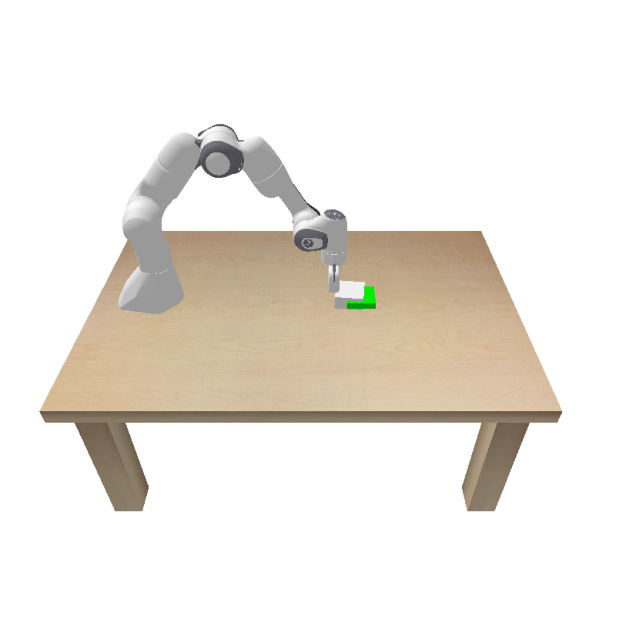

argv[0]=--opengl2
GOAL REACHED: True


In [ ]:
import pybullet as p

# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

start_state = np.array([0.4, 0.0, 0.0])
target_state = np.array([0.7, 0.0, 0.0])

# start_state = np.array([0.3, 0.3, -np.pi/2])
# target_state = np.array([0.3, -0.0, 0.0])

# start_state = np.array([0.3, 0.3, np.pi])
# target_state = np.array([0.0, 0.3, 0.0])

# start_state = np.array([0.0, 0.3, 0.0])
# target_state = np.array([0.6, 0.2, 0.0])


env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=1, grayscale=True, target_pose_vis=target_state, start_state=start_state)
env.object_target_pose = env._planar_pose_to_world_pose(target_state)
state_0 = env.reset()
controller = PushingImgSpaceController(env, sindy_dynamics_model, img_space_pushing_cost_function, normalization_constants, num_samples=100, horizon=10)

state = state_0

num_steps_max = 1000

goal_reached = False
for i in range(num_steps_max):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)

    # check if we have reached the goal
    end_pose = env.get_object_pos_planar()
    goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
    goal_reached = goal_distance < BOX_SIZE/2
    if done or goal_reached:
        break


print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)